This notebook demonstrates an experiment. Field-weighted Factorization Machine: https://arxiv.org/abs/1806.03514 is implemented as an example.

In [1]:
import datetime
import os
import pickle
from pathlib import Path

import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
from pandas import DataFrame
from tensorflow import keras

from src.config.base_configs import TrainConfig
from src.data.data_generator import DataGenerator
from src.data.cookpad import preprocessors
from src.losses import pairwise_losses
from src.utils.seed import set_seed
from src.utils.plot import plot_history
from src.metrics import metrics
from src.models.base_model import BaseModel
from src.layers.bias import AddBias0
from src.losses import pairwise_losses

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

project_dir = '../'
images_dir = f'{project_dir}/images'

In [2]:
from src.data.cookpad.recipes import load_raw_recipes

recipes = load_raw_recipes()
data_processor = preprocessors.ConcatDataProcessor(recipes)

In [3]:
def get_field_weights(model):
    weight_names = [weight.name for layer in model.layers for weight in layer.weights]
    w = None
    for name, weight in zip(weight_names, model.get_weights()):
        if 'field_weights' in name:
            w = weight
    for i in range(6):
        w[i][i] = None
    for i, j in itertools.combinations(range(6), 2):
        w[j][i] = w[i][j]
    return w

def show_field_weights(model):
    w = get_field_weights(model)
    label = ['query', 'title', 'ingredients', 'description', 'country', 'image']
    sns.heatmap(w, xticklabels=label, yticklabels=label, annot=True)
    plt.show()

In [4]:
class WeightedFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, num_fields, **kwargs):
        self.num_fields = num_fields
        super(WeightedFeatureInteraction, self).__init__(**kwargs)

    def build(self, input_shape):
        w_init = tf.constant_initializer(value=0)
        self.field_weights = tf.Variable(
            initial_value=w_init(shape=(self.num_fields, self.num_fields), dtype=tf.float32),
            name='field_weights',
        )
        self.dot = layers.Dot(axes=1, normalize=True)
        super(WeightedFeatureInteraction, self).build(input_shape)

    def call(self, inputs):
        dim = inputs.shape[1] // self.num_fields
        interactions = []
        for i, j in itertools.combinations(range(self.num_fields), 2):
            feature1, feature2 = inputs[:, i*dim:(i+1)*dim], inputs[:, j*dim:(j+1)*dim]
            interaction = self.dot([feature1, feature2])
            interaction = tf.math.scalar_mul(self.field_weights[i, j], interaction)
            interactions.append(interaction)
        return layers.concatenate(interactions)
    
    def compute_output_shape(self, input_shape):
        return None, self.num_fields

    def get_config(self):
        config = super(WeightedFeatureInteraction, self).get_config().copy()
        config.update({
            'num_fields': self.num_fields,
        })
        return config

class FwFMAll(BaseModel):
    @property
    def name(self) -> str:
        return 'fwfm_all'

    def build(self):
        text_inputs = [
            self.new_query_input(),
            self.new_title_input(),
            self.new_ingredients_input(),
            self.new_description_input(),
        ]
        country_input = self.new_country_input()
        doc_id_input = self.new_doc_id_input()
        inputs = text_inputs + [country_input, doc_id_input]

        word_embedding = layers.Embedding(self.total_words, self.embedding_dim, name='word_embedding')
        text_features = [word_embedding(text_input) for text_input in text_inputs]
        text_features = [layers.GlobalMaxPooling1D()(feature) for feature in text_features]
        country_embedding = layers.Embedding(self.total_countries, self.embedding_dim)
        country = country_embedding(country_input)
        country = tf.reshape(country, shape=(-1, self.embedding_dim,))
        image_embedding = self.load_pretrained_embedding(
            embedding_filepath="../data/raw/en_2020-03-16T00_04_34_recipe_image_tagspace5000_300.pkl",
            embedding_dim=300,
            name='image_embedding'
        )
        image = image_embedding(doc_id_input)
        image = tf.reshape(image, shape=(-1, 300,))
        image = layers.Dropout(.2)(image)
        image = layers.Dense(self.embedding_dim)(image)
        input_features = text_features + [country, image]

        interactions = []
        num_fields = len(input_features)
        features = tf.concat(input_features, axis=1)
        weighted_interaction = WeightedFeatureInteraction(num_fields)
        interactions = weighted_interaction(features)
        
        features = []
        for feature in input_features:
            feature = layers.Dense(1, activation='relu')(feature)
            features.append(feature)
        features = tf.concat(features, axis=1)
        
        x = tf.concat([features, interactions], axis=1)
        visualizer = tf.keras.Model(inputs=inputs, outputs=x)
        x = tf.keras.backend.sum(x, axis=1, keepdims=True)
        output = layers.Activation('sigmoid', name='label')(x)
        return tf.keras.Model(inputs=inputs, outputs=output, name=self.name), visualizer

In [5]:
config = TrainConfig(
    dataset_id=f'cookpad.0',
    data_processor=data_processor,
    data_processor_filename=f'concat_data_processor.0',
    model=FwFMAll,
    epochs=6,
)

In [6]:
data_processor = config.data_processor
train_df = data_processor.listwise_to_pairs(f'{config.dataset}.train.pkl')
val_df = data_processor.listwise_to_pairs(f'{config.dataset}.val.pkl')
data_processor.fit(train_df)

train_generator = DataGenerator(train_df, data_processor)
val_generator = DataGenerator(val_df, data_processor)

100%|██████████| 15625/15625 [00:00<00:00, 163964.61it/s]


In [7]:
model, visualizer = config.model(data_processor).build()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'label': pairwise_losses.cross_entropy_loss},
    metrics=['accuracy']
)
model.summary()

Model: "fwfm_all"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
doc_id (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
image_embedding (Embedding)     (None, 1, 300)       135547200   doc_id[0][0]                     
__________________________________________________________________________________________________
query (InputLayer)              [(None, 6)]          0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, 20)]         0                                            
___________________________________________________________________________________________

In [8]:
history = model.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=val_generator,
)

Epoch 1/6


/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/src/data/cookpad/preprocessors.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['author'] = df['author'].apply(lambda c: c if c in self.encoder['author'].classes_ else '')
/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/.venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['author'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


2287/2287 [==============================] - 348s 150ms/step - loss: 0.6577 - accuracy: 0.5781 - val_loss: 0.5942 - val_accuracy: 0.6595
Epoch 2/6
2287/2287 [==============================] - 371s 162ms/step - loss: 0.5571 - accuracy: 0.7108 - val_loss: 0.5756 - val_accuracy: 0.6783
Epoch 3/6
2287/2287 [==============================] - 403s 176ms/step - loss: 0.5259 - accuracy: 0.7444 - val_loss: 0.5690 - val_accuracy: 0.6843
Epoch 4/6
2287/2287 [==============================] - 408s 178ms/step - loss: 0.5094 - accuracy: 0.7634 - val_loss: 0.5654 - val_accuracy: 0.6860
Epoch 5/6
2287/2287 [==============================] - 356s 156ms/step - loss: 0.4957 - accuracy: 0.7784 - val_loss: 0.5625 - val_accuracy: 0.6901
Epoch 6/6
2287/2287 [==============================] - 384s 168ms/step - loss: 0.4878 - accuracy: 0.7876 - val_loss: 0.5617 - val_accuracy: 0.6915


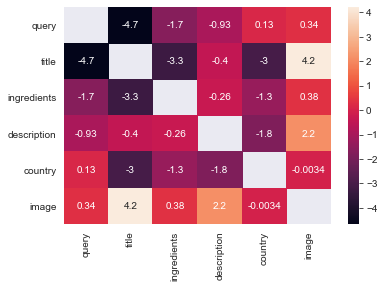

In [9]:
show_field_weights(model)

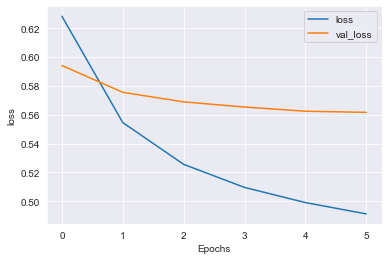

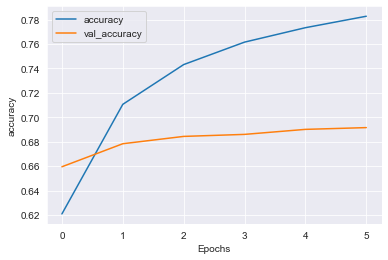

In [10]:
plot_history(history, 'loss')
plot_history(history, 'accuracy')

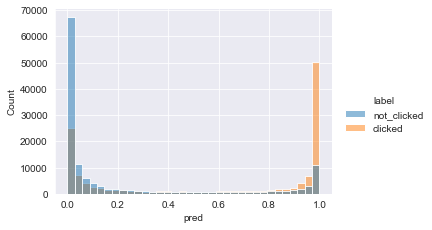

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

val_df['pred'] = model.predict(val_generator)

temp = val_df.tail(-1).copy()
temp["label"] = temp["label"].apply(lambda label: "clicked" if label == 1 else "not_clicked")
grid = sns.displot(data=temp, x='pred', hue='label')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(3)
plt.show()

y_true = val_df['label']
y_pred = val_df['pred']
round(accuracy_score(y_true, y_pred > 0.5), 4), round(precision_score(y_true, y_pred > 0.5), 4), round(recall_score(y_true, y_pred > 0.5), 4)

In [13]:
def evaluate(model, dataset, data_processor, verbose=1) -> float:
    ndcg_scores = []
    for example in (tqdm(dataset) if verbose > 0 else dataset):
        rows = []
        for doc in example['docs']:
            row = {
                'query': example['query'],
                'doc_id': doc['doc_id'],
                'label': doc['label']
            }
            rows.append(row)
        df = DataFrame(rows)
        x, y = data_processor.process_batch(df)
        dataset = tf.data.Dataset.from_tensor_slices((x, {'label': y})).batch(128)
        preds = model.predict(dataset, verbose=0)
        df['pred'] = preds
        y_true = df['label'].tolist()
        y_pred = df['pred'].tolist()
        ndcg_scores.append(metrics.normalized_discount_cumulative_gain(y_true, y_pred))

    ndcg_score = round(np.mean(ndcg_scores), 4)
    return ndcg_score

with open(f'{project_dir}/data/processed/listwise.cookpad.0.val.pkl', 'rb') as file:
    val_dataset = pickle.load(file)

ndcg_score = evaluate(model, val_dataset, data_processor)
print(f'NDCG: {ndcg_score}')

  0%|          | 0/15625 [00:00<?, ?it/s]/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/src/data/cookpad/preprocessors.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['author'] = df['author'].apply(lambda c: c if c in self.encoder['author'].classes_ else '')
/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/.venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['author'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
100%|██████████| 15625/15625 [08:51<00:00, 29.38it/s]

NDCG: 0.6754


In [14]:
features = [
    'query', 'title', 'ingredients', 'description', 'country', 'image',
    'query-title', 'query-ingredients', 'query-description', 'query-country', 'query-image',
    'title-ingredients', 'title-description', 'title-country', 'title-image',
    'ingredients-description', 'ingredients-country', 'ingredients-image',
    'description-country', 'description-image',
    'country-image',
]

In [15]:
output = visualizer.predict(val_generator)
output_with_label = np.concatenate([output, val_df['label'].to_numpy().reshape((-1,1))], axis=1)
columns = features + ['label']
output_df = DataFrame(output_with_label, columns=columns)
positive_output_df = output_df[output_df['label'] == 1]
negative_output_df = output_df[output_df['label'] == 0]

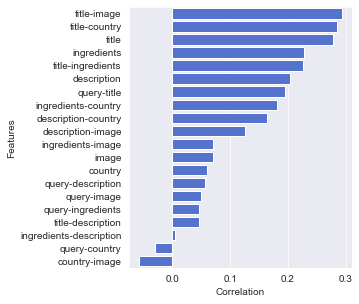

In [16]:
corr_df = output_df.corr()
corr_df = corr_df[['label']].sort_values(by='label', ascending=False).reset_index()
corr_df = corr_df.rename(columns={'index': 'feature', 'label': 'corr'})
corr_df = corr_df[corr_df['feature'] != 'label']
plt.figure(figsize=(4,4.8))
ax = sns.barplot(data=corr_df[corr_df['feature'] != 'query'], x='corr', y='feature', color='royalblue')
ax.set(xlabel='Correlation', ylabel='Features')
plt.savefig(f'{images_dir}/correlation.pdf', bbox_inches='tight')

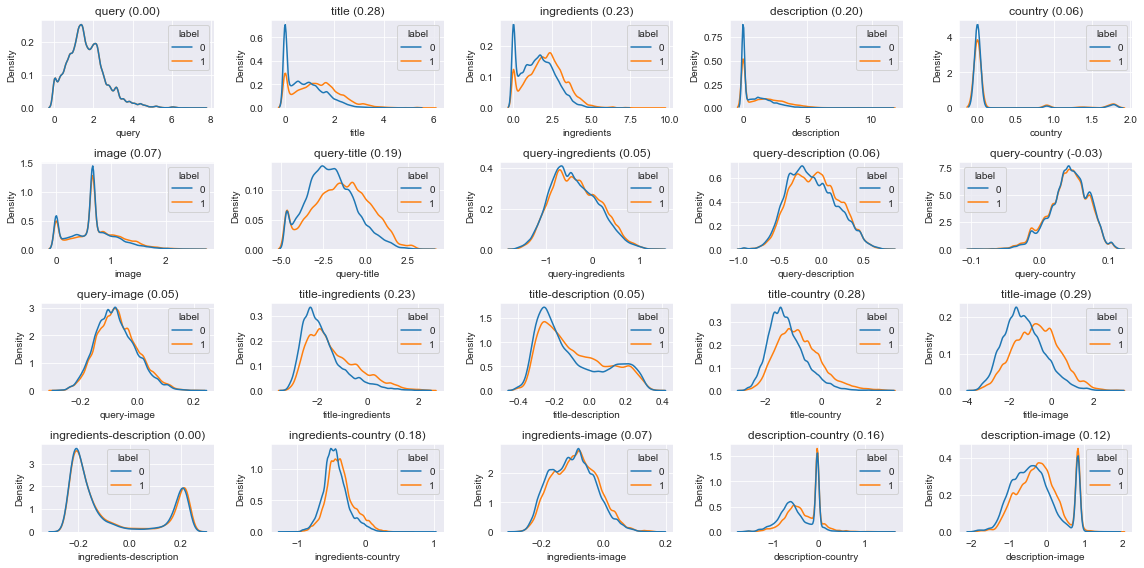

In [17]:
def plot_dist(feature, ax):
    temp_positive_output_df = pd.DataFrame(positive_output_df[feature])
    temp_positive_output_df['label'] = 1
    temp_negative_output_df = pd.DataFrame(negative_output_df[feature])
    temp_negative_output_df['label'] = 0
    temp_df = pd.concat([temp_positive_output_df, temp_negative_output_df])
    sns.kdeplot(data=temp_df, x=feature, hue='label', ax=ax)

def significance(feature):
    return corr_df[corr_df['feature'] == feature]['corr'].iloc[0]

fig, axes = plt.subplots(4, 5, figsize=(16,8))
for i in range(4):
    for j in range(5):
        idx = i * 5 + j
        if idx < len(features):
            feature = features[idx]
            plot_dist(feature, axes[i][j])
            sig = significance(feature)
            axes[i][j].set_title(f'{feature} ({sig:.2f})')
        else:
            axes[i][j].set_axis_off()
fig.tight_layout()

In [18]:
from IPython.core.display import HTML

def explain(idx, query=None, attrs=None):
    sample = val_df.iloc[idx].copy()
    recipe = recipes[sample['doc_id']].copy()
    if query:
        sample['query'] = query
    if attrs:
        sample['doc_id'] = -1
        recipe['recipe_id'] = -1
        recipe['title'] = attrs['title']
        recipe['ingredients'] = attrs['ingredients']
        recipe['story_or_description'] = attrs['description']
        recipe['country'] = attrs['country']
        data_processor.docs[-1] = recipe
    samples_df = sample.to_frame().T
    display(samples_df)
    display(HTML(f"<b>query</b>: {sample['query']}"))
    display(HTML(f"<b>title</b>: {recipe['title']}"))
    display(HTML(f"<b>ingredients</b>: {','.join(recipe['ingredients'])}"))
    display(HTML(f"<b>description</b>: {recipe['story_or_description']}"))
    display(HTML(f"<b>country</b>: {recipe['country']}"))
    data = data_processor.process_batch(samples_df)
    dataset = tf.data.Dataset.from_tensor_slices((data))
    generator = dataset.cache().batch(1)
    pred = model.predict(generator)[0][0]
    display(HTML(f"<b>pred</b>: {pred:.2f}"))
    output = visualizer.predict(generator)[0]
    rows = []
    for i in range(len(features)):
        rows.append({
            'feature': features[i],
            'value': output[i],
        })
    temp = DataFrame(rows).sort_values(by=['value'], ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(data=temp, x='value', y='feature', color='royalblue')
    plt.show()

,query,doc_id,label,pred
20486,kalabasa,4825916,1,0.983024


/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/src/data/cookpad/preprocessors.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['author'] = df['author'].apply(lambda c: c if c in self.encoder['author'].classes_ else '')
/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/.venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['author'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


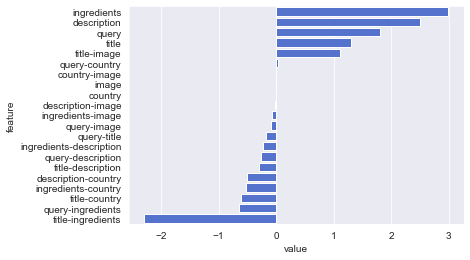

,query,doc_id,label,pred
20487,kalabasa,3512454,0,0.00222984


/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/src/data/cookpad/preprocessors.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['author'] = df['author'].apply(lambda c: c if c in self.encoder['author'].classes_ else '')


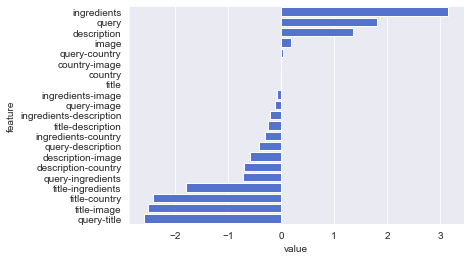

In [19]:
explain(20486) # positive example of "breakfast"
explain(20487) # negative example of "breakfast"

,query,doc_id,label,pred
5812,shrimp,-1,1,0.0897328


/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/src/data/cookpad/preprocessors.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['author'] = df['author'].apply(lambda c: c if c in self.encoder['author'].classes_ else '')


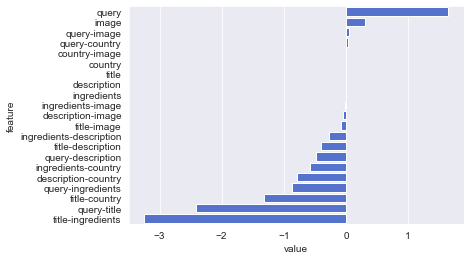

,query,doc_id,label,pred
5812,shrimp,-1,1,0.0897328


/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/src/data/cookpad/preprocessors.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  df['author'] = df['author'].apply(lambda c: c if c in self.encoder['author'].classes_ else '')


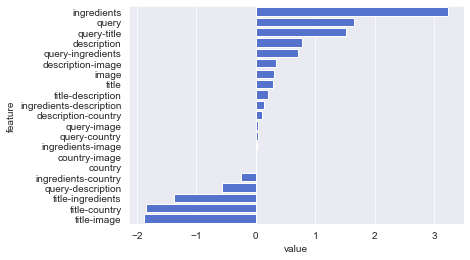

In [20]:
explain(
    idx=5812,
    query='shrimp',
    attrs={
        'title': 'water',
        'ingredients': ['water'],
        'description': 'water',
        'country': 'US'
    }
)

explain(
    idx=5812,
    query='shrimp',
    attrs={
        'title': 'Tasty bisque with shrimps',
        'ingredients': ['onion', 'carrots', 'leek', 'tomato', 'shirmps', 'garlic'],
        'description': 'Yummy',
        'country': 'US'
    }
)